In [1]:
import numpy as np
from tqdm import tqdm
import numpy as np
import pandas as pd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.svm import SVC
from SVM import OVO_test, OVO_train
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def rgb2gray(x):
    #last axis of x must be the number of axis
    return x@[0.2125, 0.7154, 0.0721]

def plot_image(image, ax):
    im = np.zeros_like(image)
    for i in range(3):
        channel_min = np.min(image[:,:,i], keepdims=True)
        channel_max = np.max(image[:,:,i], keepdims=True)
        im[:,:,i] = (image[:,:,i] - channel_min) / (channel_max - channel_min)
    ax.imshow(im)

In [2]:
Xtr = pd.read_csv('data/Xtr.csv',header=None,sep=',',usecols=range(3072))
Xte = pd.read_csv('data/Xte.csv',header=None,sep=',',usecols=range(3072))
Ytr_ = pd.read_csv('data/Ytr.csv')#, index_col = None, header = None)

In [3]:
Xtr = np.array(Xtr).reshape(5000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Xte = np.array(Xte).reshape(2000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Ytr = np.array(Ytr_['Prediction'])
X_tot = np.vstack([Xtr, Xte]) #Entire dataset used for feature extraction

# Feature learning

In [17]:
def extract_random_patch(image, rf_size):
    corner = np.random.randint(32 - rf_size, size=2)
    i,j = corner[0], corner[1]
    patch = image[i:i+rf_size, j:j+rf_size, :]
    patch = patch - np.mean(patch)
    patch/=(np.std(patch)+1)
    return patch

def extract_patches(dataset, num_patches, rf_size):
    patches = np.zeros((num_patches, rf_size*rf_size*3))
    for i in tqdm(range(num_patches)):
        img_idx = i%len(dataset)
        patch = extract_random_patch(dataset[img_idx], rf_size)
        patches[i] = patch.reshape(-1)
    return patches 

def cluster_patches(patches, k):
    clust = KMeans(n_clusters=k, verbose=True, max_iter = 50, n_init = 5)
    clust.fit(patches)
    return clust.labels_, clust.cluster_centers_

def whiten_patches(patches):
    
    C = np.cov(patches, rowvar=False)  
    M = np.mean(patches, axis=0)
    d, V = np.linalg.eigh(C)
    D = np.diag(np.sqrt(1. / (d + 0.1)))
    P = np.matmul(np.matmul(V, D), V.T)
    feats = np.matmul(patches - M, P)

    return feats, M, P 

In [9]:
##Extract
patches = extract_patches(X_tot, 200000, 6)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:09<00:00, 21314.14it/s]


In [10]:
##Whiten
patches, M, P = whiten_patches(patches)

In [18]:
##Cluster
labels, centroids = cluster_patches(patches, 400)

Initialization complete
Iteration 0, inertia 206532.25419022283
Iteration 1, inertia 181925.33883606287
Iteration 2, inertia 177991.10711232966
Iteration 3, inertia 176476.02002122992
Iteration 4, inertia 175647.62224888385
Iteration 5, inertia 175118.89025355192
Iteration 6, inertia 174739.64118818464
Iteration 7, inertia 174449.70786500603
Iteration 8, inertia 174218.5697543741
Iteration 9, inertia 174031.59073859017
Iteration 10, inertia 173879.3761579661
Iteration 11, inertia 173754.5707108807
Iteration 12, inertia 173654.06466535403
Iteration 13, inertia 173568.4164030593
Iteration 14, inertia 173493.64582109876
Iteration 15, inertia 173427.8571282446
Iteration 16, inertia 173372.34947852266
Iteration 17, inertia 173323.08182535873
Iteration 18, inertia 173279.51004244387
Iteration 19, inertia 173240.05954337647
Iteration 20, inertia 173204.13740277977
Iteration 21, inertia 173172.75667681312
Iteration 22, inertia 173143.3448902176
Iteration 23, inertia 173116.12039618194
Iteratio

Initialization complete
Iteration 0, inertia 204851.1655019885
Iteration 1, inertia 182170.8688088918
Iteration 2, inertia 178083.52773578314
Iteration 3, inertia 176500.1448338513
Iteration 4, inertia 175628.80296116546
Iteration 5, inertia 175072.6382593671
Iteration 6, inertia 174687.02444455688
Iteration 7, inertia 174408.28804595582
Iteration 8, inertia 174194.2093185182
Iteration 9, inertia 174023.9747454359
Iteration 10, inertia 173886.94873977263
Iteration 11, inertia 173774.89771784257
Iteration 12, inertia 173681.02006178474
Iteration 13, inertia 173604.58981290617
Iteration 14, inertia 173540.1153923081
Iteration 15, inertia 173485.57228049403
Iteration 16, inertia 173437.3345291316
Iteration 17, inertia 173392.75739985734
Iteration 18, inertia 173352.38307453587
Iteration 19, inertia 173314.60864039848
Iteration 20, inertia 173278.18225217267
Iteration 21, inertia 173244.40892749385
Iteration 22, inertia 173214.819202848
Iteration 23, inertia 173187.6198685045
Iteration 24,

# Feature extraction

In [58]:
def get_quarters(img):
    img_size = img.shape[0]
    half_size = img_size//2
    q1 = img[:half_size, :half_size,:]
    q2 = img[half_size:, :half_size,:]
    q3 = img[:half_size, half_size:,:]
    q4 = img[half_size:, half_size:,:]
    return [q1, q2, q3, q4]

def compute_features_patch(patch, centroids):
    k = len(centroids)
    z = np.zeros(k)
    for i, centroid in enumerate(centroids):
        z[i] = np.linalg.norm(patch - centroid)
    f =  np.maximum(np.zeros(k), np.mean(z)*np.ones(k) - z)
    return f

def compute_features_img(img, centroids, stride, patch_size):
    k = len(centroids)
    img_feat = np.zeros(k)
    img_size = img.shape[0]
    i = 0
    while i+patch_size < img_size:
        j = 0
        while j+patch_size < img_size:
            patch = img[i:i+patch_size, j:j+patch_size,:]
            patch = patch.reshape(-1)
            
            patch = (patch - patch.mean())/(patch.std()+1) #normalize
            patch = np.matmul(patch - M, P) #whiten
            j+=stride
            f = compute_features_patch(patch, centroids)
            img_feat += f
            #print(i,j)
        i+=stride
    return img_feat

def compute_features(dataset, centroids, stride, patch_size, M, P):
    k = len(centroids)
    X = np.zeros(len(dataset), 4*400)
    #X = []    
    for i, img in tqdm(enumereate(dataset)):
        quart = get_quarters(img)
        #f = []
        f = np.zeros(4*k)
        for i in range(4):
            quarter_feats = compute_features_img(quart[i], centroids, stride, patch_size)
            f[k*i:k*(i+1)] = quarter_feats #k features per quarter
        #print(f.shape)
        X[i] = f
    #X = X.reshape(len(X), -1)
    return X

def post_processing(X):
    X -= X.mean(axis=0, keepdims=True)
    X /= (0.01 + np.std(X, axis=0))
    #X = np.hstack([X, np.ones((len(X), 1))])
    return X


In [38]:
#dataset = Xtr_
#dataset.shape
X_train = compute_features(Xtr, centroids, stride=1, patch_size=6, M = M, P = P)
X_test = compute_features(Xte, centroids, stride=1, patch_size=6, M = M, P = P)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [21:38<00:00,  1.54it/s]


In [59]:
X_train = np.load('data/X_train.npy')
X_test= np.load('data/X_test.npy')

X_train = post_processing(X_train)
X_test = post_processing(X_test)

In [76]:
X_tr, X_te, y_tr = X_train, X_test, Ytr

In [77]:
classifier = SVC(C=10, decision_function_shape='ovo', tol = 0.01)
classifier.fit(X_tr, y_tr)

SVC(C=10, decision_function_shape='ovo', tol=0.01)

In [78]:
pred = classifier.predict(X_te)

In [79]:
np.save("pred_j_test.npy", pred)

In [75]:
accuracy_score(pred, y_te)

0.534

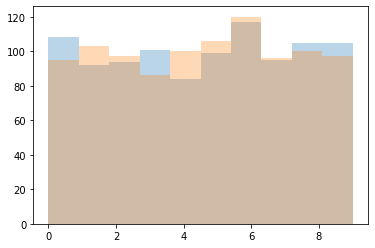

In [54]:
plt.hist(pred, alpha=0.3)
plt.hist(y_te, alpha=0.3)
plt.show()

In [103]:
import os 
import pickle
dataset_dir = '/Users/jeanelkhoury/Desktop/MVA/kernel/unsupervised-feature-learning/ext/alisher_research/cifar-10-batches-py'
def load_from_pickle(filepath):
    with open(filepath, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='latin1')

    return data_dict
f1 = load_from_pickle(os.path.join(dataset_dir, 'data_batch_1'))

In [118]:
import joblib
trainXCs = joblib.load('/Users/jeanelkhoury/Desktop/MVA/kernel/unsupervised-feature-learning/ext/alisher_research/trainXCs.joblib')

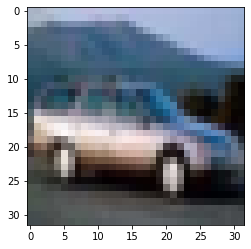

In [114]:
data = f1['data'].reshape(-1, 3, 32, 32).swapaxes(1,2).swapaxes(2,3)

plt.imshow(data[4])